In [192]:
from pydub import AudioSegment
from pydub.utils import make_chunks
from pyaudio import PyAudio
from threading import Thread
from matplotlib.pyplot import figure
import pandas as pd
import time
import random
import scipy.io
import os
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
import mat73
import parselmouth
import seaborn as sns



- https://www.cambridge.org/core/journals/apsipa-transactions-on-signal-and-information-processing/article/advances-in-antispoofing-from-the-perspective-of-asvspoof-challenges/6B5BB5B75A49022EB869C7117D5E4A9C
- https://www.sciencedirect.com/science/article/pii/S0167639316301091?casa_token=ZtsK_HHzbNoAAAAA:r4uOTyx_0Y1hUntEHoqM6d6kQrp71uZmi5JQwc8F-rgVpba0NyUrIorpesjg-b6Chgvk-JtH
- https://www.researchgate.net/publication/320401863_Synthetic_speech_detection_using_fundamental_frequency_variation_and_spectral_features

In [34]:
class Song(Thread):

    def __init__(self, f, *args, **kwargs):
        self.seg = AudioSegment.from_file(f)
        self.__is_paused = True
        self.p = PyAudio()
        print(self.seg.frame_rate)
        Thread.__init__(self, *args, **kwargs)
        self.start()

    def pause(self):
        self.__is_paused = True

    def play(self):
        self.__is_paused = False

    def __get_stream(self):
        return self.p.open(format=self.p.get_format_from_width(self.seg.sample_width),
                           channels=self.seg.channels,
                           rate=self.seg.frame_rate,
                           output=True)

    def run(self):
        stream = self.__get_stream()
        chunk_count = 0
        chunks = make_chunks(self.seg, 100)
        while chunk_count <= len(chunks):
            if not self.__is_paused:
                data = (chunks[chunk_count])._data
                chunk_count += 1
            else:
                free = stream.get_write_available()
                data = chr(0)*free
            stream.write(data)

        stream.stop_stream()
        self.p.terminate()



In [83]:
# extract cqt
def extract_cqt(filename):
    try:
        fulldatasetpath = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_train/flac'
#         print(fulldatasetpath + '/' +filename + '.flac')
        y, sr = librosa.load(fulldatasetpath + '/' +filename + '.flac')
        C = np.abs(librosa.cqt(y, sr=sr)) 
    except Exception as e:
        print("Error encountered while parsing file: ", filename)
        return None 
     
    return C,sr

    
    

In [49]:
dev_cm_protocol_LA = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt'
train_cm_protocol_LA = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
la_train_base_path = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_train/flac/'

In [133]:
attack_dict = { '-' : 'Bonafide',
'A01': 'A01 TTS neural waveform model',
'A02': 'A02 TTS vocoder',
'A03': 'A03 TTS vocoder',
'A04': 'A04 TTS waveform concatenation',
'A05': 'A05 VC vocoder',
'A06': 'A06 VC spectral filtering'}

In [18]:
dev_cm_pl = pd.read_csv(dev_cm_protocol_LA,delimiter = " ", header=None)
dev_cm_pl.columns = ['SPEAKER_ID','AUDIO_FILE_NAME','ENVIRONMENT_ID','ATTACK_ID','KEY']

train_cm_pl = pd.read_csv(train_cm_protocol_LA,delimiter = " ", header=None)
train_cm_pl.columns = ['SPEAKER_ID','AUDIO_FILE_NAME','ENVIRONMENT_ID','ATTACK_ID','KEY']

In [41]:
speakers = train_cm_pl['SPEAKER_ID'].unique()

In [42]:
attacks = train_cm_pl.loc[(train_cm_pl['SPEAKER_ID'] == 'LA_0079')]['ATTACK_ID'].unique()

In [60]:
all_attacks = []
for attack in attacks:
    file = train_cm_pl.loc[(train_cm_pl['SPEAKER_ID'] == speakers[0]) & (train_cm_pl['ATTACK_ID'] == attack) ]['AUDIO_FILE_NAME'].values[0]
    all_attacks.append({
        'ATTACK_ID': attack,
        'AUDIO_FILE_NAME' : file,
        'SPEAKER_ID' : speakers[0]
        
    })

    

In [64]:
random.shuffle(all_attacks)

In [217]:
song = Song(la_train_base_path + all_attacks[1]['AUDIO_FILE_NAME'] + '.flac')
song.play()
print(all_attacks[1])

16000
{'ATTACK_ID': '-', 'AUDIO_FILE_NAME': 'LA_T_1138215', 'SPEAKER_ID': 'LA_0079'}


## Playing one speaker with all 6 attacks shuffled randomly

In [204]:
for audio in all_attacks:
    print('This is Attack :', attack_dict[audio['ATTACK_ID']])
    song = Song(la_train_base_path + audio['AUDIO_FILE_NAME'] + '.flac')
    song.play()
    time.sleep(4)

This is Attack : A06 VC spectral filtering
16000
This is Attack : Bonafide
16000


Exception in thread Thread-122:
Traceback (most recent call last):
  File "/Users/asimadnan/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "<ipython-input-34-3683d87965b0>", line 29, in run
IndexError: list index out of range
Exception in thread Thread-123:
Traceback (most recent call last):
  File "/Users/asimadnan/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "<ipython-input-34-3683d87965b0>", line 29, in run
IndexError: list index out of range


This is Attack : A05 VC vocoder
16000
This is Attack : A04 TTS waveform concatenation
16000


Exception in thread Thread-125:
Traceback (most recent call last):
  File "/Users/asimadnan/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "<ipython-input-34-3683d87965b0>", line 29, in run
IndexError: list index out of range
Exception in thread Thread-124:
Traceback (most recent call last):
  File "/Users/asimadnan/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "<ipython-input-34-3683d87965b0>", line 29, in run
IndexError: list index out of range


This is Attack : A03 TTS vocoder
16000


Exception in thread Thread-126:
Traceback (most recent call last):
  File "/Users/asimadnan/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "<ipython-input-34-3683d87965b0>", line 29, in run
IndexError: list index out of range


This is Attack : A02 TTS vocoder
16000
This is Attack : A01 TTS neural waveform model
16000


Exception in thread Thread-127:
Traceback (most recent call last):
  File "/Users/asimadnan/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "<ipython-input-34-3683d87965b0>", line 29, in run
IndexError: list index out of range
Exception in thread Thread-128:
Traceback (most recent call last):
  File "/Users/asimadnan/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "<ipython-input-34-3683d87965b0>", line 29, in run
IndexError: list index out of range


## visualisaing all attacks of same speaker with CQCC,CQT etc

## CQT (Constant-Q transform) & VQT (variable-Q transform)


{'ATTACK_ID': 'A06', 'AUDIO_FILE_NAME': 'LA_T_1033197', 'SPEAKER_ID': 'LA_0079'}


/Users/asimadnan/opt/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


{'ATTACK_ID': '-', 'AUDIO_FILE_NAME': 'LA_T_1138215', 'SPEAKER_ID': 'LA_0079'}
{'ATTACK_ID': 'A05', 'AUDIO_FILE_NAME': 'LA_T_1029621', 'SPEAKER_ID': 'LA_0079'}
{'ATTACK_ID': 'A04', 'AUDIO_FILE_NAME': 'LA_T_1006715', 'SPEAKER_ID': 'LA_0079'}
{'ATTACK_ID': 'A03', 'AUDIO_FILE_NAME': 'LA_T_1007408', 'SPEAKER_ID': 'LA_0079'}
{'ATTACK_ID': 'A02', 'AUDIO_FILE_NAME': 'LA_T_1025525', 'SPEAKER_ID': 'LA_0079'}
{'ATTACK_ID': 'A01', 'AUDIO_FILE_NAME': 'LA_T_1004644', 'SPEAKER_ID': 'LA_0079'}


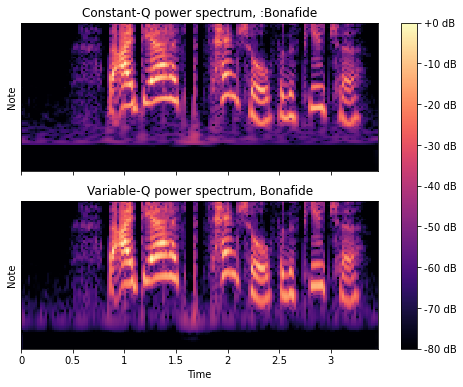

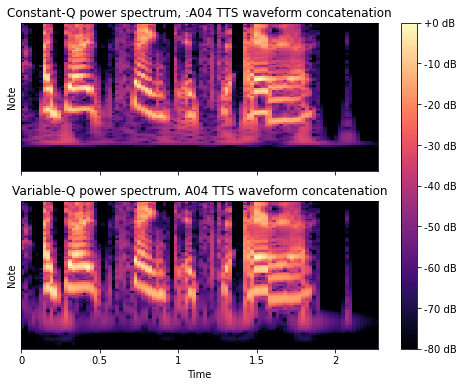

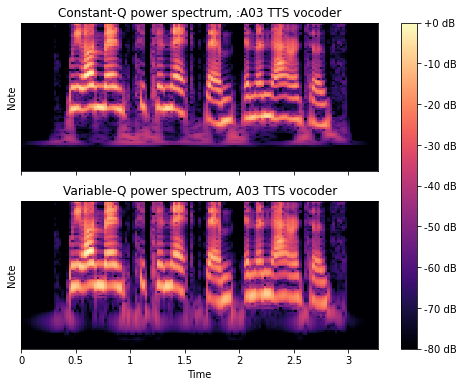

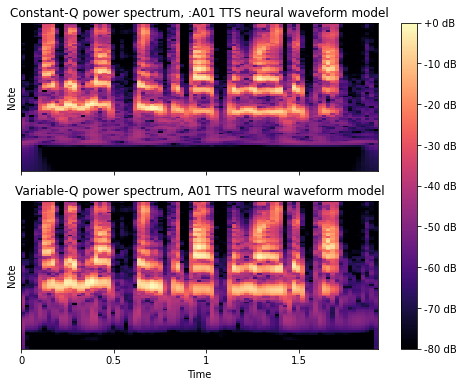

In [139]:
for audio in all_attacks:    
    print(audio)
    file = la_train_base_path + audio['AUDIO_FILE_NAME'] + '.flac'
    
    y, sr = librosa.load(file)
    C = np.abs(librosa.cqt(y, sr=sr))
    V = np.abs(librosa.vqt(y, sr=sr))
    
    fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
    fig.set_size_inches(8,6)
    
    librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                             sr=sr, x_axis='time', y_axis='cqt_note', ax=ax[0])
    ax[0].set(title='Constant-Q power spectrum, :' + attack_dict[audio['ATTACK_ID']], xlabel=None)
    
    ax[0].label_outer()
    
    img = librosa.display.specshow(librosa.amplitude_to_db(V, ref=np.max),
                                   sr=sr, x_axis='time', y_axis='cqt_note', ax=ax[1])
    ax[1].set_title('Variable-Q power spectrum, '+ attack_dict[audio['ATTACK_ID']])
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    
    
    

## Fourier tempogram

/Users/asimadnan/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=384 is too small for input signal of length=195
  warnings.warn(
/Users/asimadnan/opt/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/asimadnan/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=384 is too small for input signal of length=149
  warnings.warn(
/Users/asimadnan/opt/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/asimadnan/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum

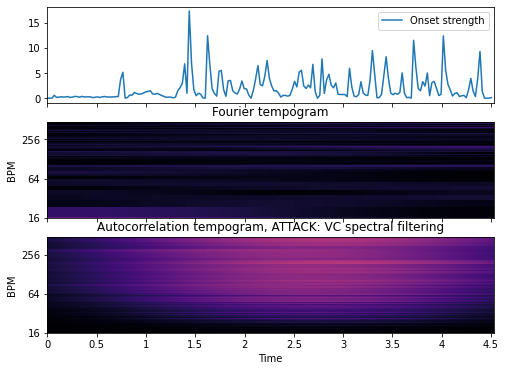

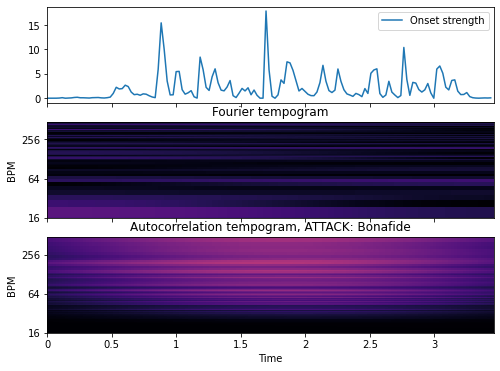

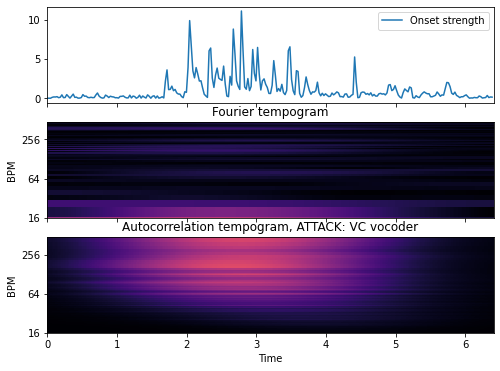

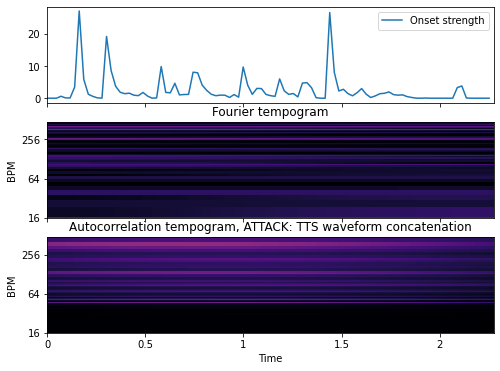

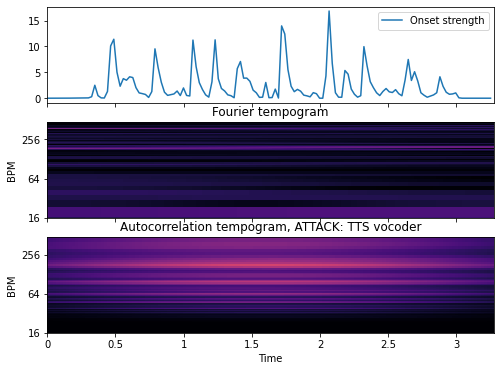

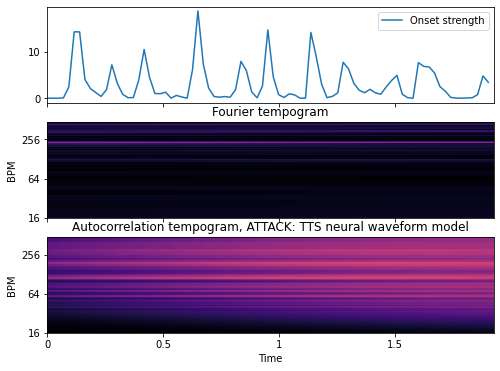

In [126]:
for audio in all_attacks:
    file = la_train_base_path + audio['AUDIO_FILE_NAME'] + '.flac'
    y, sr = librosa.load(file)
    hop_length = 512
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    tempogram = librosa.feature.fourier_tempogram(onset_envelope=oenv, sr=sr,
                                                  hop_length=hop_length)
    # Compute the auto-correlation tempogram, unnormalized to make comparison easier
    ac_tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,
                                             hop_length=hop_length, norm=None)

#     figure(figsize=(8, 6), dpi=80)
    fig, ax = plt.subplots(nrows=3, sharex=True)
    fig.set_size_inches(8,6)
    ax[0].plot(librosa.times_like(oenv), oenv, label='Onset strength')
    ax[0].legend(frameon=True)
    ax[0].label_outer()
    librosa.display.specshow(np.abs(tempogram), sr=sr, hop_length=hop_length,
                             x_axis='time', y_axis='fourier_tempo', cmap='magma',
                             ax=ax[1])
    ax[1].set(title='Fourier tempogram')
    ax[1].label_outer()
    librosa.display.specshow(ac_tempogram, sr=sr, hop_length=hop_length,
                             x_axis='time', y_axis='tempo', cmap='magma',
                             ax=ax[2])
    ax[2].set(title='Autocorrelation tempogram, ATTACK: ' + attack_dict[audio['ATTACK_ID']])
   

## Short-time Fourier transform (STFT).

/Users/asimadnan/opt/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/asimadnan/opt/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/asimadnan/opt/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


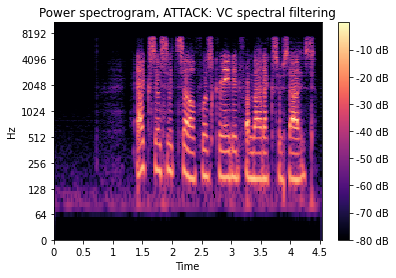

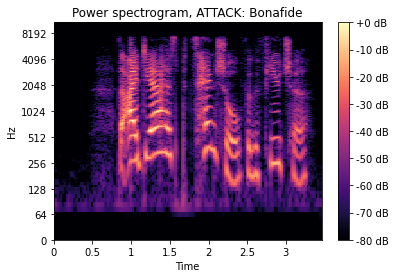

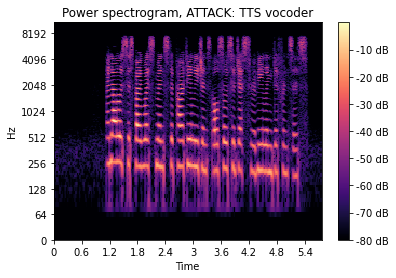

In [128]:
for audio in all_attacks:
    file = la_train_base_path + audio['AUDIO_FILE_NAME'] + '.flac'
    y, sr = librosa.load(file)
    S = np.abs(librosa.stft(y))
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    img = librosa.display.specshow(librosa.amplitude_to_db(S,
                                                           ref=np.max),
                                   y_axis='log', x_axis='time', ax=ax)
    ax.set_title('Power spectrogram, ATTACK: ' + attack_dict[audio['ATTACK_ID']])
    fig.colorbar(img, ax=ax, format="%+2.0f dB")

## Time-frequency reassigned spectrogram.



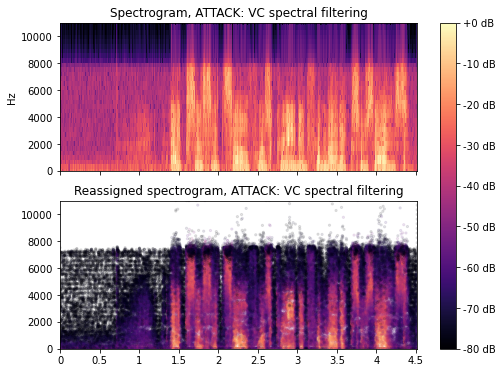

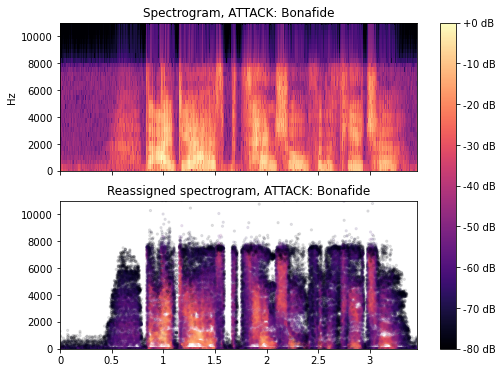

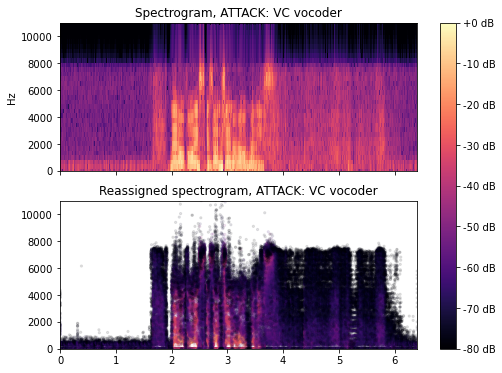

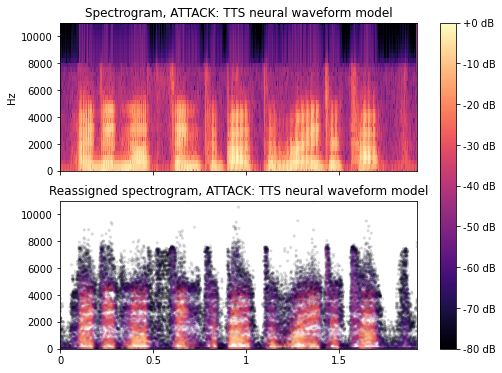

In [132]:
for audio in all_attacks:
    file = la_train_base_path + audio['AUDIO_FILE_NAME'] + '.flac'
    y, sr = librosa.load(file)
    amin = 1e-10
    n_fft = 64
    freqs, times, mags = librosa.reassigned_spectrogram(y=y, sr=sr,
                                                    n_fft=n_fft)
    mags_db = librosa.power_to_db(mags, ref=np.max)
    fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
    fig.set_size_inches(8,6)
    img = librosa.display.specshow(mags_db, x_axis="s", y_axis="linear", sr=sr,
                             hop_length=n_fft//4, ax=ax[0])
    ax[0].set(title="Spectrogram, ATTACK: " + attack_dict[audio['ATTACK_ID']], xlabel=None)
    ax[0].label_outer()
    ax[1].scatter(times, freqs, c=mags_db, cmap="magma", alpha=0.1, s=5)
    ax[1].set_title("Reassigned spectrogram, ATTACK: " + attack_dict[audio['ATTACK_ID']])
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    


# Time-frequency representation using IIR filters

/Users/asimadnan/opt/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


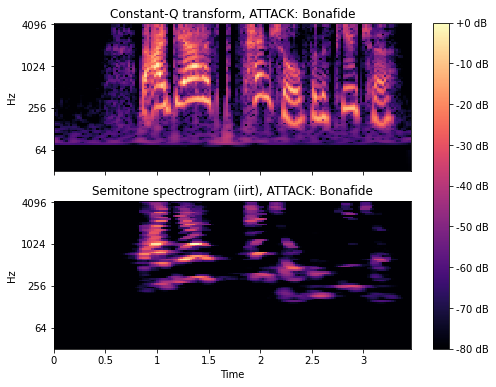

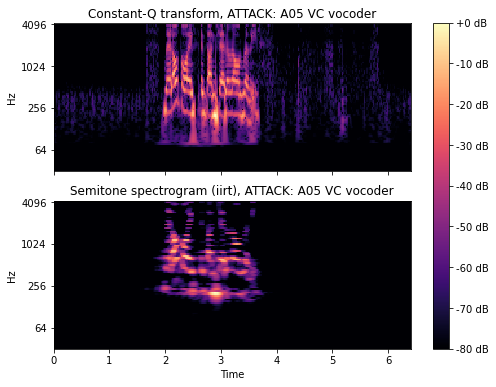

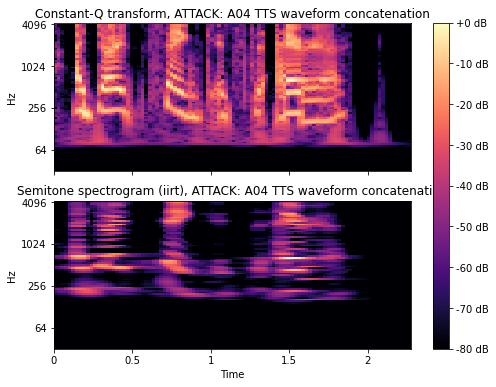

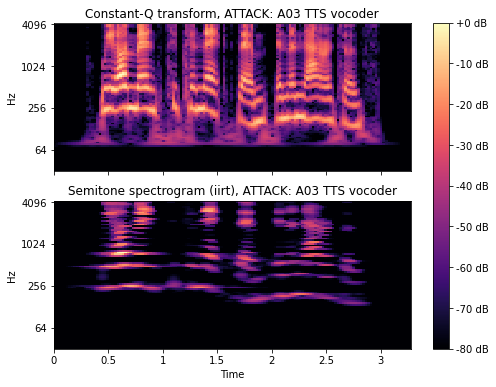

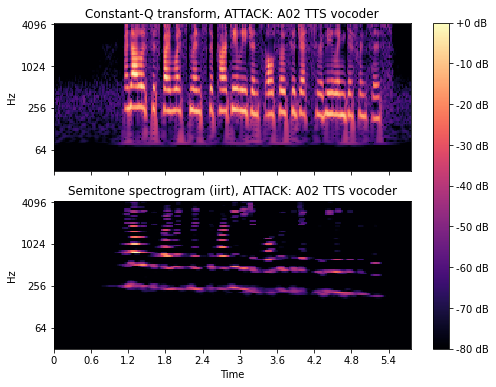

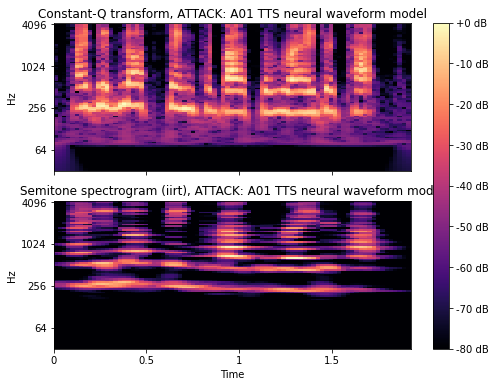

In [141]:
for audio in all_attacks:
    file = la_train_base_path + audio['AUDIO_FILE_NAME'] + '.flac'
    y, sr = librosa.load(file)
    D = np.abs(librosa.iirt(y))
    C = np.abs(librosa.cqt(y=y, sr=sr))
    fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
    fig.set_size_inches(8,6)
    img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                                   y_axis='cqt_hz', x_axis='time', ax=ax[0])
    ax[0].set(title='Constant-Q transform, ATTACK: ' + attack_dict[audio['ATTACK_ID']])
    ax[0].label_outer()
    img = librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                                   y_axis='cqt_hz', x_axis='time', ax=ax[1])
    ax[1].set_title('Semitone spectrogram (iirt), ATTACK: ' + attack_dict[audio['ATTACK_ID']])
    fig.colorbar(img, ax=ax, format="%+2.0f dB")

# Approximate magnitude spectrogram inversion using the “fast” Griffin-Lim algorithm.





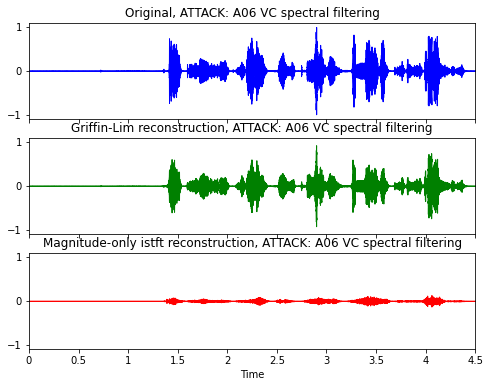

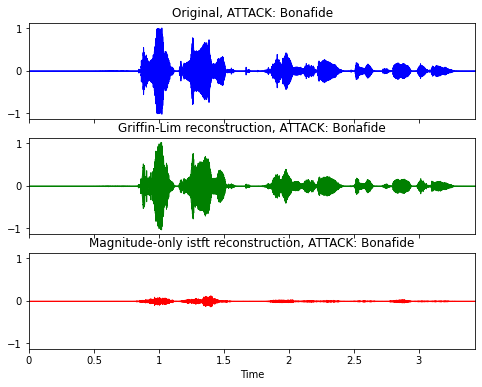

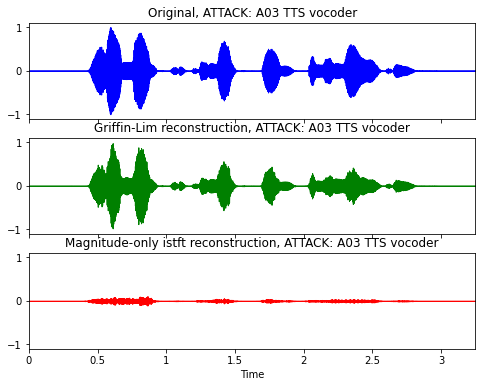

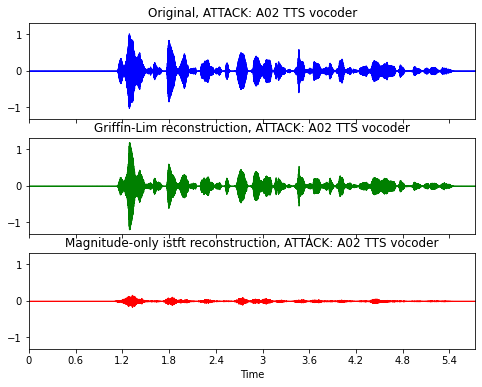

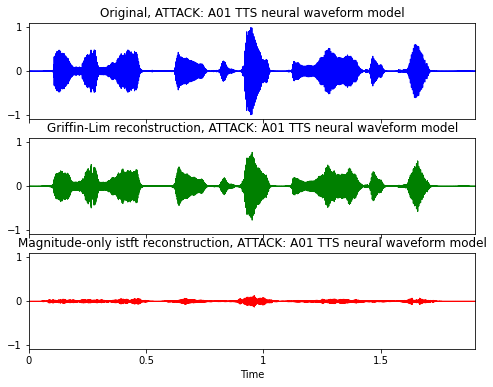

In [143]:
for audio in all_attacks:
    file = la_train_base_path + audio['AUDIO_FILE_NAME'] + '.flac'
    y, sr = librosa.load(file)
    # Get the magnitude spectrogram
    S = np.abs(librosa.stft(y))
    # Invert using Griffin-Lim
    y_inv = librosa.griffinlim(S)
    # Invert without estimating phase
    y_istft = librosa.istft(S)

    fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
    fig.set_size_inches(8,6)
    librosa.display.waveplot(y, sr=sr, color='b', ax=ax[0])
    ax[0].set(title='Original, ATTACK: ' + attack_dict[audio['ATTACK_ID']], xlabel=None)
    ax[0].label_outer()
    librosa.display.waveplot(y_inv, sr=sr, color='g', ax=ax[1])
    ax[1].set(title='Griffin-Lim reconstruction, ATTACK: ' + attack_dict[audio['ATTACK_ID']], xlabel=None)
    ax[1].label_outer()
    librosa.display.waveplot(y_istft, sr=sr, color='r', ax=ax[2])
    ax[2].set_title('Magnitude-only istft reconstruction, ATTACK: ' + attack_dict[audio['ATTACK_ID']])

# MFCC

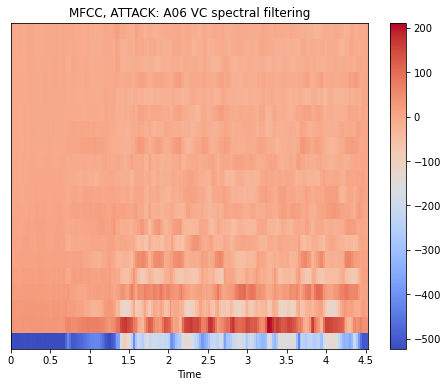

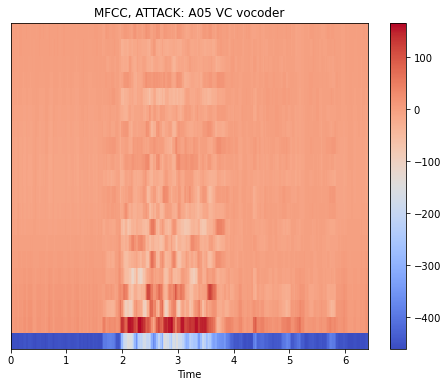

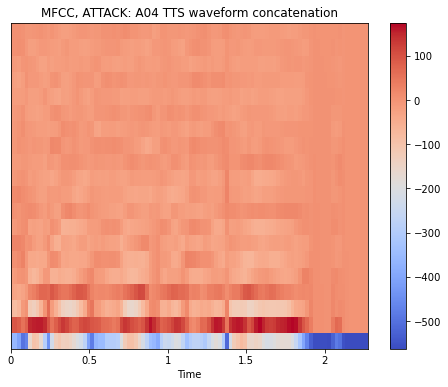

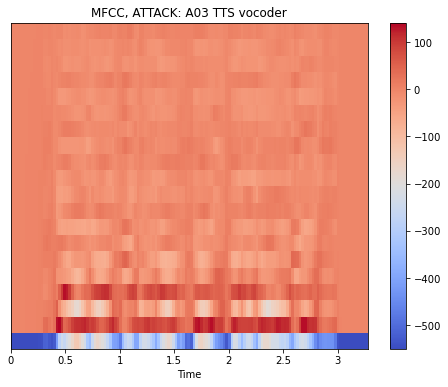

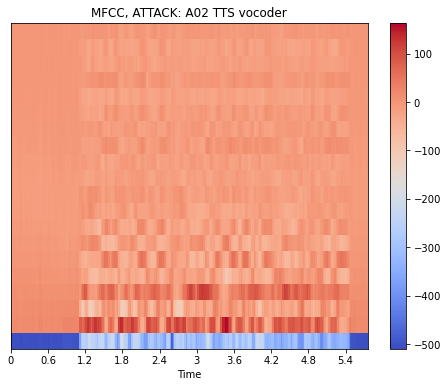

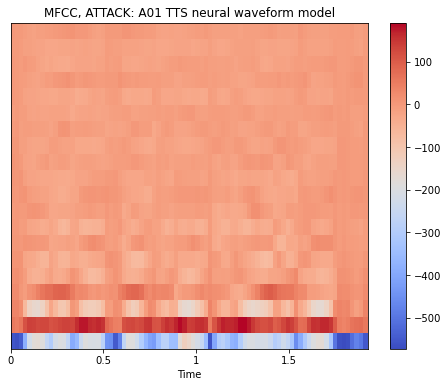

In [146]:
for audio in all_attacks:
    file = la_train_base_path + audio['AUDIO_FILE_NAME'] + '.flac'
    
    y, sr = librosa.load(file)
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    fig, ax = plt.subplots()
    fig.set_size_inches(8,6)
    img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
    fig.colorbar(img, ax=ax)
    ax.set(title='MFCC, ATTACK: ' + attack_dict[audio['ATTACK_ID']])


# CQCC - Matlab

In [164]:
matlab_cqcc_path_bon = '/Users/asimadnan/Desktop/Mres/ASVspoof_2019_baseline_CM_v1/genuineFeatureCellLaTrainSample.mat'
matlab_cqcc_path_spoof = '/Users/asimadnan/Desktop/Mres/ASVspoof_2019_baseline_CM_v1/spoofFeatureCellLaTrainSample.mat'

In [165]:
matlab_cqcc_bon = scipy.io.loadmat(matlab_cqcc_path)
matlab_cqcc_spoof = scipy.io.loadmat(matlab_cqcc_path_spoof)


In [182]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
img = librosa.display.specshow(matlab_cqcc_bon['genuineFeatureCell'][0][0], x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)

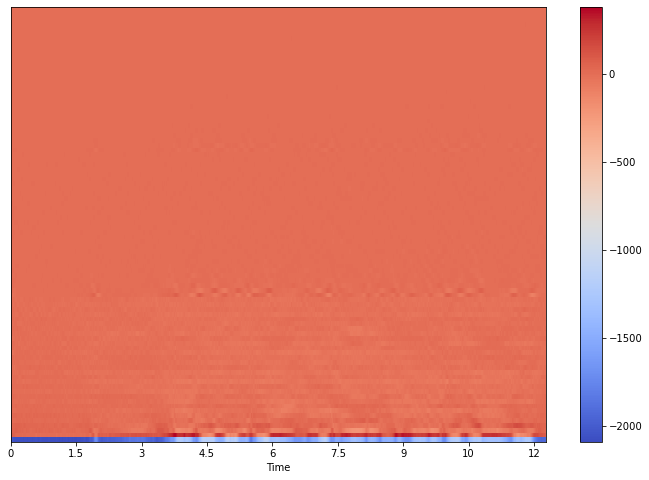

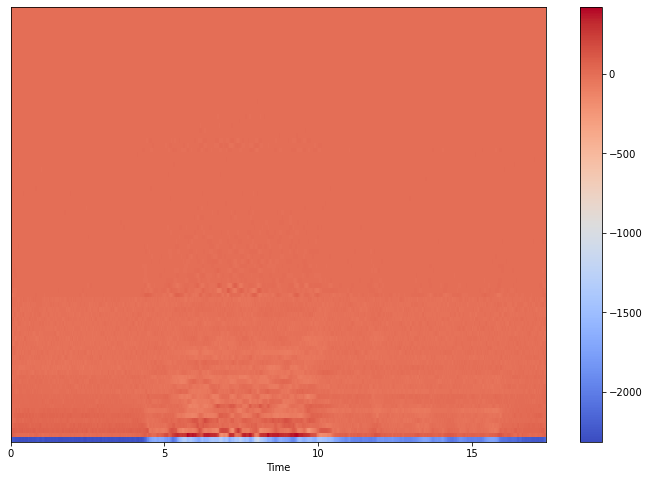

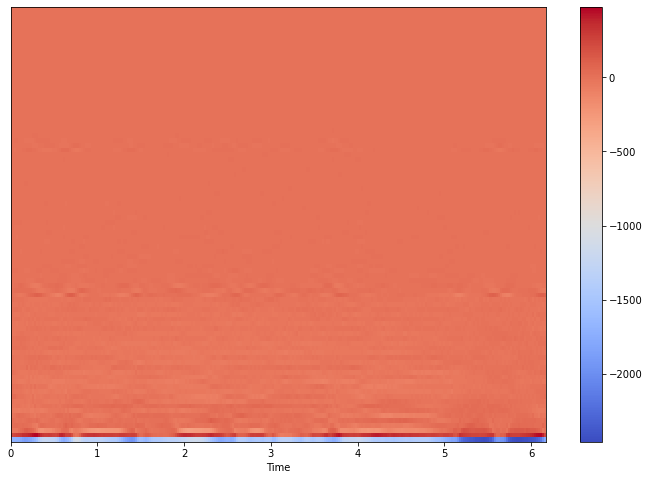

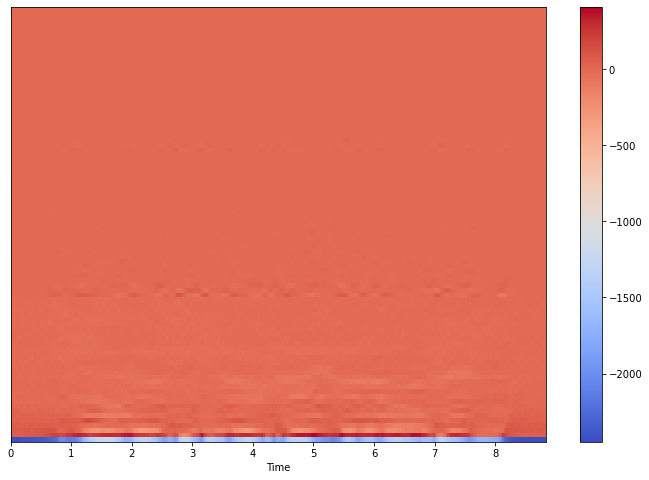

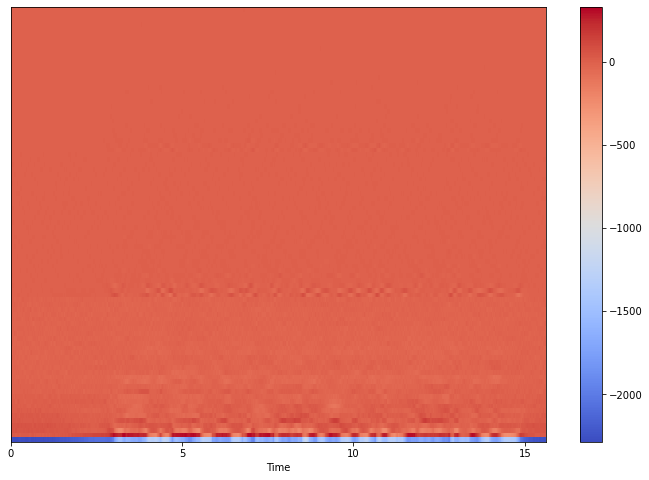

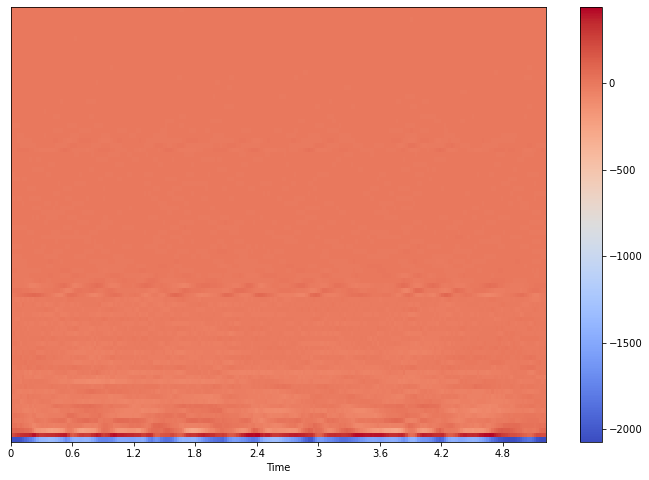

In [188]:
for spoof in matlab_cqcc_spoof['spoofFeatureCell']:
#     print(spoof[0].shape)
    fig, ax = plt.subplots()
    fig.set_size_inches(12,8)
    img = librosa.display.specshow(spoof[0], x_axis='time', ax=ax)
    fig.colorbar(img, ax=ax)

# Pitch

In [219]:
def draw_spectrogram(spectrogram, dynamic_range=70,attack=''):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]"+ ', Attack:' + attack)
    plt.ylabel("frequency [Hz]" + ', Attack:' + attack)

def draw_intensity(intensity,attack=''):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]" )
    plt.xlabel('Attack:' + attack)

def draw_pitch(pitch,attack=''):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")
    plt.xlabel('Attack:' + attack)



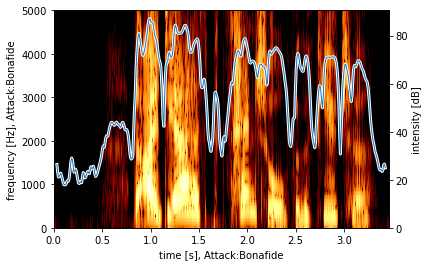

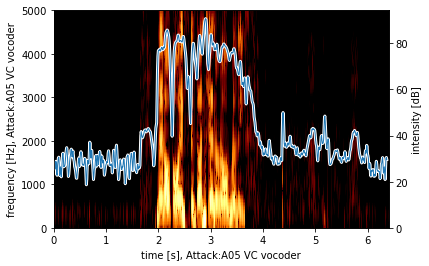

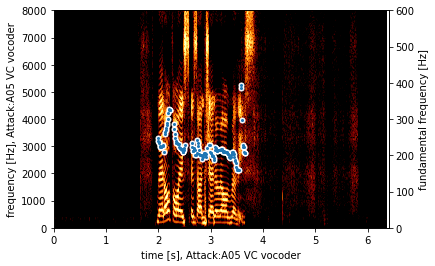

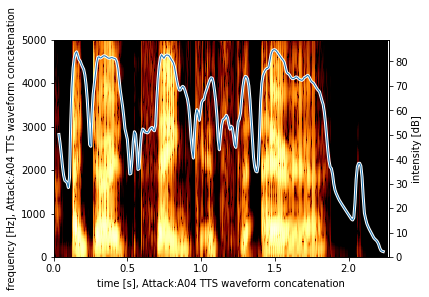

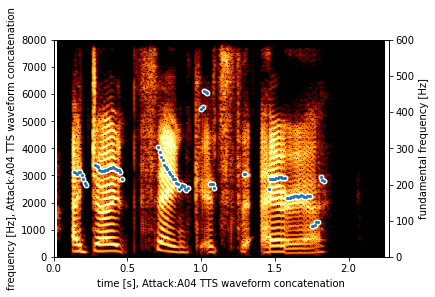

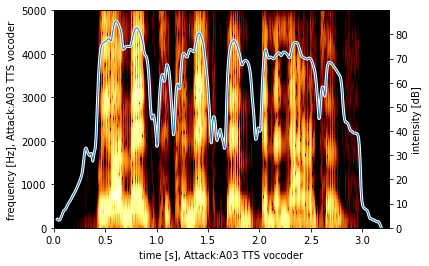

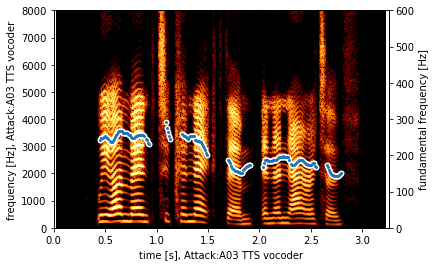

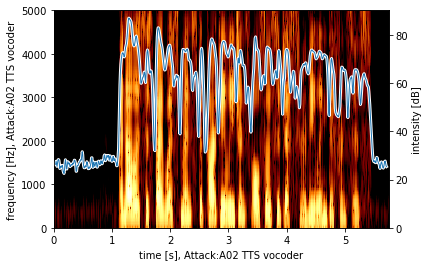

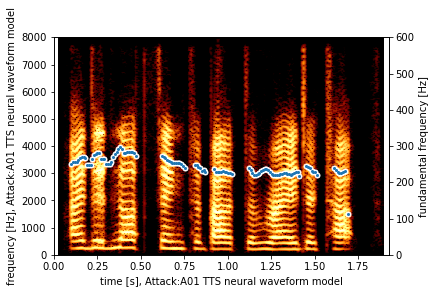

In [220]:
for audio in all_attacks:
    file = la_train_base_path + audio['AUDIO_FILE_NAME'] + '.flac'
    snd = parselmouth.Sound(file)
    intensity = snd.to_intensity()
    spectrogram = snd.to_spectrogram()
    plt.figure()
    draw_spectrogram(spectrogram,attack=attack_dict[audio['ATTACK_ID']])
    plt.twinx()
    draw_intensity(intensity,attack=attack_dict[audio['ATTACK_ID']])
    plt.xlim([snd.xmin, snd.xmax])
    plt.show() # or plt.savefig("spectrogram.pdf")

    pitch = snd.to_pitch()
    # If desired, pre-emphasize the sound fragment before calculating the spectrogram
    pre_emphasized_snd = snd.copy()
    pre_emphasized_snd.pre_emphasize()
    spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)
    plt.figure()
    draw_spectrogram(spectrogram,attack=attack_dict[audio['ATTACK_ID']])
    plt.twinx()
    draw_pitch(pitch,attack=attack_dict[audio['ATTACK_ID']])
    plt.xlim([snd.xmin, snd.xmax])
    plt.show() # or plt.savefig("spectrogram_0.03.pdf")
    